## Martin Dionne

In [1]:
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re

# 1. Twitch API data

The URL `https://wind-bow.glitch.me/twitch-api/channels/{CHANNEL_NAME}` is an API from twitch to get data from twitch channels.

Get the data from the following channels:

```
["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]
```

To make into a dataframe that looks like this:

![](twitch.png)

In [2]:
channels = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas", "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", "tsm_bjergsen", "boxbox", "wtcn", "a_seagull","kinggothalion", "amazhs", "jahrein", "thenadeshot", "sivhd", "kingrichard"]

df = pd.DataFrame()
for c in channels:
    r = requests.get(f'https://wind-bow.glitch.me/twitch-api/channels/{c}')
    if r.status_code == 200:
        df = pd.concat([df, pd.DataFrame.from_dict(json.loads(r.content))])

In [3]:
df = (
    df[['_id','display_name','status','followers','views']]
    .drop_duplicates(ignore_index=True)
    .rename({'_id':'id'}, axis='columns')
)

df

,id,display_name,status,followers,views
0,30220059,ESL_SC2,RERUN: StarCraft 2 - Terminator vs. Parting (P...,135394,60991791
1,71852806,OgamingSC2,UnderDogs - Rediffusion - Qualifier.,40895,20694507
2,90401618,cretetion,It's a Divison kind of Day,908,11631
3,79776140,FreeCodeCamp,Greg working on Electron-Vue boilerplate w/ Ak...,10122,163747
4,86238744,storbeck,None,10,1019
5,6726509,Habathcx,Massively Effective,14,764
6,54925078,RobotCaleb,Code wrangling,20,4602
7,82534701,noobs2ninjas,Building a new hackintosh for #programming and...,835,48102


# 2. App Store Reviews

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country code (eg. `'us'`, `'gb'`, `'ca'`, `'au'`) 

- The app ID. This can be found in the web page for the app right after `id`. For instance, Candy Crush's US webpage is:

`https://apps.apple.com/us/app/candy-crush-saga/id553834731`

So here the ID would be `553834731`.

- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country.

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

Note: `df.title.str.get_dummies()` is your friend

Note: This might create a lot of data! Try to break down your analysis in chunks if it doesn't work.

In [4]:
# 2.1 Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter

In [5]:
apps = ['candycrush', 'tinder', 'twitter', 'facebook']
ids = [553834731, 547702041, 333903271, 284882215]
countries = ['us', 'gb', 'ca', 'au', 'nz', 'ie', 'za', 'jm', 'bs']

df = pd.DataFrame()

for id in ids:

    for cc in countries:
        pg = 1
        comments = []
        version = []
        rating = []
        country = []
        app = []

        url = f'https://itunes.apple.com/{cc}/rss/customerreviews/id={id}/page={pg}/sortby=mostrecent/json'
        r = requests.get(url)

        while r.status_code == 200:
            j = json.loads(r.content)
            try:
                comments += [ e['content']['label'] for e in j['feed']['entry'] ]
                version += [ e['im:version']['label'] for e in j['feed']['entry'] ]
                rating += [ e['im:rating']['label'] for e in j['feed']['entry'] ]
                pg += 1
                url = f'https://itunes.apple.com/{cc}/rss/customerreviews/id={id}/page={pg}/sortby=mostrecent/json'
                r = requests.get(url)
                #print(pg)
            except:
                r.status_code = 999

        country = [cc for _ in range(0,len(version))]
        app = [id for _ in range(0,len(version))]
    
        lists = [app, country, version, rating, comments]
        df = pd.concat([df, pd.DataFrame(lists).transpose()])

df.columns = ['app','country','version','rating', 'comments']
df['app'] = df['app'].replace(ids,apps)

In [6]:
df.sample(10)

,app,country,version,rating,comments
69,facebook,us,305.0,1,People are creating an Avatar and on the botto...
171,facebook,au,301.0,1,Censorship and Facebook community standards ha...
180,facebook,us,305.0,3,Every new update messes up something. Current...
201,tinder,nz,10.9.1,1,"Like many other reviews, banned for no reason!..."
217,candycrush,au,1.171.0.1,3,"Bring back the C’s, they disappeared a few da..."
291,facebook,nz,269.0,1,I lost my facebook accounts twice. What's wron...
319,facebook,ie,204.0,2,"Hi, your app is keep hanging on iPhone for som..."
220,twitter,nz,7.21.2,1,Stop locking my accounts for no reason it’s se...
225,tinder,za,10.17.0,5,"Its an easy app to use, also my girlfriend and..."
239,tinder,ca,11.30.0,1,"Just scroll through the most recent reviews, t..."


In [7]:
# 2.2 For each app, get the version that is the best rated.

In [8]:
# Keep versions with at least 20 reviews
df.rating = df.rating.astype(int)
tmp = df.groupby(by=['app','version']).filter(lambda x : len(x)>20)
tmp = tmp.groupby(by=['app','version']).rating.mean().sort_values(ascending=False)

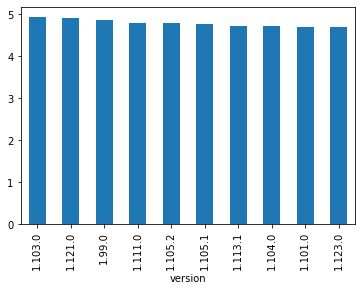

In [10]:
tmp['candycrush'][:10].plot.bar();

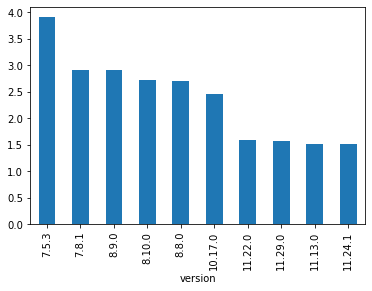

In [11]:
tmp['tinder'][:10].plot.bar();

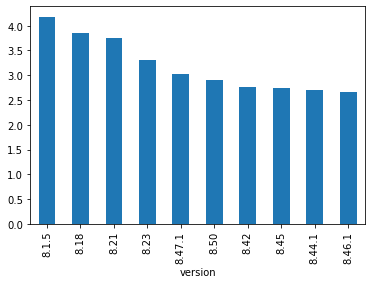

In [12]:
tmp['twitter'][:10].plot.bar();

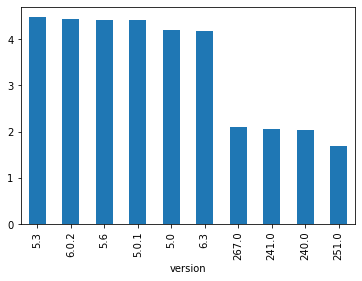

In [13]:
tmp['facebook'][:10].plot.bar();

In [14]:
# 2.3 Which word for each app is most common in the 5 star and in the 1-star review's titles?

In [21]:
import string 
from sklearn.feature_extraction import text

stop_words = text.ENGLISH_STOP_WORDS.union(["", "it’s", "app"])
dx = df.copy()

dx['comments'] = dx['comments'].str.lower().str.replace('[{}]'.format(string.punctuation),'')
dx['comments'] = dx['comments'].str.split(' ')
dx['comments'] = dx['comments'].apply(lambda x: [item for item in x if item not in stop_words])

words = pd.DataFrame()

for app in apps:
    for r in [1,5]:
        tmp = dx.loc[(dx.app == app) & (df.rating == r)]
        words[app+'_rating_'+str(r)] = tmp.comments.str.join(' ').str.split(' ', expand=True).stack().value_counts()[:10].index

In [22]:
words

,candycrush_rating_1,candycrush_rating_5,tinder_rating_1,tinder_rating_5,twitter_rating_1,twitter_rating_5,facebook_rating_1,facebook_rating_5
0,game,game,tinder,tinder,twitter,twitter,facebook,facebook
1,level,love,banned,good,speech,love,update,love
2,levels,fun,account,love,people,great,just,great
3,just,great,people,great,account,good,people,best
4,play,addictive,just,people,free,people,can’t,good
5,playing,good,reason,met,platform,best,account,like
6,money,candy,got,just,don’t,like,don’t,friends
7,candy,play,don’t,like,like,social,fb,awesome
8,time,crush,time,thank,censorship,news,like,new
9,boosters,playing,i’m,don’t,just,use,time,fb


# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`

In [23]:
import time
import random as ran

In [24]:
# Extract data from movie "cards"
def get_card_data(card):
    
    mdata = {}
  
    mdata['movie'] = card.find('h3',{'class': 'lister-item-header'}).find( 'a').get_text()    
    mdata['year'] = str(card.find('span',{'class': 'lister-item-year'}).contents[0][1:-1])
    mdata['imdb'] = float(card.find('div',{'class':'inline-block ratings-imdb-rating'}).get('data-value'))

    try:
        mdata['metascore'] = float(card.find('span',{'class':re.compile('metascore *')}).contents[0].strip())
    except:
        mdata['metascore'] = None

    mdata['votes'] = int(card.find('span',{'name':'nv'}).get('data-value'))

    try:
        mdata['us_grossMillions'] = round(float(card.find_all('span',{'name':'nv'})[1].get('data-value').replace(',',''))/1e6,2)
    except:
        mdata['us_grossMillions'] = None

    mdata['timeMin'] = int(card.find('span',{'class':'runtime'}).contents[0].replace(" min",""))

    return mdata

In [25]:
headers = {"Accept-Language": "en-US,en;q=0.5"}
PAGE_NUMBER = 1
rows = []

# Get Top 1000 movies
while PAGE_NUMBER <= 1000:
    url = f'https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt'
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content, 'html.parser')
    cards = soup.find_all('div', {'class':'lister-item mode-advanced'})
    for card in cards:
        rows.append(get_card_data(card))
    PAGE_NUMBER += 50
    time.sleep(ran.randint(0, 10))

In [26]:
df = pd.DataFrame(rows)
df

,movie,year,imdb,metascore,votes,us_grossMillions,timeMin
0,Soul,2020,8.1,83.0,177939,NaN,100
1,Avengers: Endgame,2019,8.4,78.0,818791,858.37,181
2,The Sound of Music,1965,8.0,63.0,207262,163.21,172
3,The Trial of the Chicago 7,2020,7.8,77.0,97388,NaN,129
4,Dara of Jasenovac,2020,8.7,NaN,52913,NaN,130
...,...,...,...,...,...,...,...
995,Lage Raho Munna Bhai,2006,8.0,NaN,43225,2.22,144
996,M.S. Dhoni: The Untold Story,2016,7.8,NaN,40601,1.78,184
997,The Breath,2009,8.0,NaN,31910,NaN,128
998,Vizontele,2001,8.0,NaN,33705,NaN,110
